# Pre-processing of NYC Trip Records Dataset
Our goal in this project is to forecast hourly commercial transportation demand for taxi zones in New York City. For this goal, we plan on making use of the NYC Taxi and Limousine Commission (TLC) Trip Record Data and Hourly weather records taken on New York City. For now, we do not have access to weather data in hourly resolution. Therefore we made our analysis and exploration on NYC Yellow Taxi Records for the year (2023). To this end, our goal as a first step is to load the NYC trip records and do basic exploratory data analysis to determine the required pre-processing steps. For this, we first loaded the trip records into pandas data frames. Examined the individual trip records to look for faulty records to obtain a reliable dataset develop our models.

To use in the models we develop, we aim to have the dataset with the following features:

| Lattitude | Longitude | Hour | Day of week | Day of Year | Month | Quarter | Temperature | Wind | Humidity | Air quality | Demand |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| float | float | int{0-23} | int{0-6} | int{0-364} | int{0-12} | int{0-3} | float | float | float | float | int |

## Examination of Yellow Taxi Trip Records:

In [1]:
import os, sys
from pathlib import Path

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
import numpy as np
import pandas as pd


BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
YELLOW_DIR = DATA_DIR / 'yellow_taxi_trip_records'
GREEN_DIR = DATA_DIR / 'green_taxi_trip_records'
FHV_DIR = DATA_DIR / 'for_hire_vehicle_trip_records'

def load_monthly_trip_data(start_month, end_month=None, dataset='yellow', drop_other_columns=False):
    """Load NYC rideshare trip records for specified month(s)

    Parameters
    ----------
    start_month : str
        The start month in 'YYYY-MM' format
    end_month : str, optional
        The end month in 'YYYY-MM' format. If not specified, only the start month will be loaded
    dataset: str, optional
        The dataset to load. Default is 'yellow'. Other options are 'green' and 'for_hire'

    Returns
    -------
    list of pandas.DataFrame
        A list of DataFrames containing the trip data for each month
    """
    if end_month is None:
        end_month = start_month
    
    if dataset == 'yellow':
        dataset_path = YELLOW_DIR
    elif dataset == 'green':
        dataset_path = GREEN_DIR
    elif dataset == 'for_hire':
        dataset_path = FHV_DIR
    else:
        raise ValueError("Invalid dataset. Please specify 'yellow', 'green', or 'for_hire'")
    
    if not dataset_path.exists():
        raise FileNotFoundError(f"Directory for '{dataset}' is not found in {dataset_path}")
    
    if drop_other_columns:
        columns = ['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','DOLocationID']
    else:
        columns = None

    dates = pd.date_range(start_month, end_month, freq='MS')
    months = [date.strftime('%Y-%m') for date in dates]
    monthly_trip_records = [pd.read_parquet(dataset_path / f'yellow_tripdata_{month}.parquet',
                                            columns=columns)
                            for month in months]
    return monthly_trip_records

In [2]:
raw_monthly_trip_datasets = load_monthly_trip_data('2023-01', '2023-12', 'yellow')
print("Month 2019-01 Records:\n ------------------------------------ \n")
raw_monthly_trip_datasets[0].head()
raw_monthly_trip_datasets[0].info()


Month 2019-01 Records:
 ------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  co

The trip records include 19 records which can be seen above. Among these, we are primarily interested in the `tpep_pickup_datetime` and `PULocationID` which respectively encode the time stamp of the start of the trip and the pick up location. However, with the use of `tpep_dropoff_datetime`, we can look for anomalous entries within the records that contain logical errors.

Per our analysis, the records are not perfect and have the following issues,
- Pick-up and drop-off time stamps of the trips are faulty. 
    - **Issue 1:**

        Trips recorded under a specific months record whose time stamps indicate other months/years. Mostly next/previous hour from end or beginning of the month.
    - **Issue 2:**

        Trip records with pick up time stamp later than or equal to the drop-off time stamp.

### Examples of Logical Errors in NYC Trip Records
- **Issue 1:**

In [3]:
month_begin_ts = pd.Timestamp('2023-01')
next_month_ts = month_begin_ts + pd.offsets.MonthBegin()
raw_monthly_trip_datasets[0][raw_monthly_trip_datasets[0]['tpep_pickup_datetime'] < month_begin_ts].head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
80,2,2022-12-31 23:51:30,2022-12-31 23:56:06,1.0,0.86,1.0,N,141,140,1,6.5,1.0,0.5,2.00,0.0,1.0,13.50,2.5,0.0
567,2,2022-12-31 23:59:37,2023-01-01 00:07:28,1.0,2.38,1.0,N,142,151,1,12.1,1.0,0.5,4.28,0.0,1.0,21.38,2.5,0.0
761,2,2022-12-31 23:58:27,2023-01-01 00:02:21,1.0,0.49,1.0,N,229,237,1,5.8,1.0,0.5,0.08,0.0,1.0,10.88,2.5,0.0
900,2,2022-12-31 23:44:31,2022-12-31 23:48:47,1.0,0.52,1.0,N,233,162,1,5.8,1.0,0.5,2.16,0.0,1.0,12.96,2.5,0.0
1177,2,2022-12-31 23:59:25,2023-01-01 00:19:21,2.0,3.65,1.0,N,141,68,1,19.1,1.0,0.5,7.23,0.0,1.0,31.33,2.5,0.0


- **Issue 2:**

In [4]:
raw_monthly_trip_datasets[0][raw_monthly_trip_datasets[0]['tpep_pickup_datetime'] >=  raw_monthly_trip_datasets[0]['tpep_dropoff_datetime']].head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3291,1,2023-01-01 00:11:55,2023-01-01 00:11:55,1.0,0.0,5.0,Y,137,264,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4971,1,2023-01-01 01:54:01,2023-01-01 01:54:01,1.0,0.0,1.0,N,237,264,2,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0
11648,1,2023-01-01 02:45:08,2023-01-01 02:45:08,1.0,0.0,1.0,N,234,264,2,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0
15664,1,2023-01-01 03:55:38,2023-01-01 03:55:38,1.0,0.0,1.0,N,48,264,2,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0
22644,1,2023-01-01 07:24:56,2023-01-01 07:24:56,1.0,0.0,1.0,Y,116,264,2,10.7,2.5,0.5,0.0,0.0,1.0,14.7,0.0,0.0


In [5]:
def detect_faulty_records_in_monthly_record(month_record, month, only_stats=False):
    """Detect records with faulty time-stamps in the monthly trip record
    
    Detect records with the following issues:
    1. Drop-off time earlier than or equal to the pick-up time
    2. Pick-up time earlier than the begining of the month
    3. Pick-up time later than end of the month
    Parameters:
    month_record : pandas.DataFrame
        The monthly trip record
    month : str
        The month in 'YYYY-MM' format

    """
    month_begin_ts = pd.Timestamp(month)
    next_month_ts = month_begin_ts + pd.offsets.MonthBegin()

    early_rows = month_record['tpep_pickup_datetime'] < month_begin_ts
    late_rows = month_record['tpep_pickup_datetime'] >= next_month_ts
    pu_lateroe_than_do = month_record['tpep_pickup_datetime'] >= month_record['tpep_dropoff_datetime']
    pul_nan = month_record['PULocationID'].isnull()
    do_nan = month_record['DOLocationID'].isnull()
    if only_stats:
        return sum(early_rows), sum(late_rows), sum(pu_lateroe_than_do), sum(pul_nan), sum(do_nan)
    else:
        return early_rows, late_rows, pu_lateroe_than_do, pul_nan, do_nan

start_month = '2023-01'
end_month = '2023-12'
dates = pd.date_range(start_month, end_month, freq='MS')
months = [date.strftime('%Y-%m') for date in dates]
for i, month in enumerate(months):
    print(f"-------------------------\n Checking month {month}\n-------------------------")
    stats = detect_faulty_records_in_monthly_record(raw_monthly_trip_datasets[i], month, only_stats=True)
    print(f"Pick-up earlier than month start: {stats[0]}/{raw_monthly_trip_datasets[i].shape[0]} = {stats[0]/raw_monthly_trip_datasets[i].shape[0]:.4%}")
    print(f"Pick-up later than month end: {stats[1]}/{raw_monthly_trip_datasets[i].shape[0]} = {stats[1]/raw_monthly_trip_datasets[i].shape[0]:.4%}")
    print(f"Pick-up later than or equal to the drop-off: {stats[2]}/{raw_monthly_trip_datasets[i].shape[0]} = {stats[2]/raw_monthly_trip_datasets[i].shape[0]:.4%}")
    print("Null Pick-up Locations: ", stats[3])
    print("Null Drop-off Locations: ", stats[4])

-------------------------
 Checking month 2023-01
-------------------------
Pick-up earlier than month start: 38/3066766 = 0.0012%
Pick-up later than month end: 10/3066766 = 0.0003%
Pick-up later than or equal to the drop-off: 1121/3066766 = 0.0366%
Null Pick-up Locations:  0
Null Drop-off Locations:  0
-------------------------
 Checking month 2023-02
-------------------------
Pick-up earlier than month start: 13/2913955 = 0.0004%
Pick-up later than month end: 42/2913955 = 0.0014%
Pick-up later than or equal to the drop-off: 1265/2913955 = 0.0434%
Null Pick-up Locations:  0
Null Drop-off Locations:  0
-------------------------
 Checking month 2023-03
-------------------------
Pick-up earlier than month start: 104/3403766 = 0.0031%
Pick-up later than month end: 85/3403766 = 0.0025%
Pick-up later than or equal to the drop-off: 1453/3403766 = 0.0427%
Null Pick-up Locations:  0
Null Drop-off Locations:  0
-------------------------
 Checking month 2023-04
-------------------------
Pick-up 

# Pre-processing: 
Since these records are very rare and we have a large number of trip records, we chose to discard those trip records that exhibit *Issue 1* or *Issue 2*. We discretize the date range into hourly periods and count the number of trip records for every taxi zone. For every hour, we create new features `dayofweek`, `dayofyear`, `month`, `quarter` that encode the date information.

In [29]:
from tqdm import tqdm
def load_and_count_trip_records(start_month, end_month=None, freq='h', dataset='yellow', drop_other_columns=True, taxi_zones=None):
    """Parse the monthly trip record and count the number of records with faulty time-stamps
    
    Parameters:
    monthly_record : pandas.DataFrame
        The monthly trip record
    month : str
        The month in 'YYYY-MM' format

    Returns:
    pandas.DataFrame
        A DataFrame containing the parsed trip records
    """
    dates = pd.date_range(start_month, end_month, freq='MS')
    months = [date.strftime('%Y-%m') for date in dates]
    monthly_trip_records = load_monthly_trip_data(start_month, end_month, dataset, drop_other_columns)
    
    monthly_trip_counts = []
    for i, month in tqdm(enumerate(months)):
        early_rows, late_rows, pu_lateroe_than_do, pul_nan, do_nan = detect_faulty_records_in_monthly_record(monthly_trip_records[i], month)
        monthly_trip_records[i] = monthly_trip_records[i][~(early_rows | late_rows | pu_lateroe_than_do | pul_nan | do_nan)]

        monthly_trip_counts.append(monthly_trip_records[i].resample(freq, on='tpep_pickup_datetime').agg({'PULocationID': 'value_counts'}))
        
        monthly_trip_counts[i].rename(columns={'PULocationID': 'PU_count'}, inplace=True)
        monthly_trip_counts[i] = monthly_trip_counts[i].reorder_levels([1,0])

        mstart = pd.Timestamp(month)
        mend = mstart + pd.offsets.MonthBegin()
        datetime_index = pd.date_range(mstart, mend, freq=freq)[:-1]
        zones_index = range(1,266, 1)
        multi_index = pd.MultiIndex.from_product([zones_index, datetime_index], names=['PULocationID', 'datetime'])
        monthly_trip_counts[i] = monthly_trip_counts[i].reindex(multi_index, fill_value=0).sort_index()

        if taxi_zones is not None:
            location_filter = monthly_trip_records[i]['PULocationID'].isin(taxi_zones.zones.LocationID.to_list())
            monthly_trip_records[i] = monthly_trip_records[i][location_filter]

    trip_counts = pd.concat(monthly_trip_counts, axis=0).sort_index()
    return trip_counts

In [25]:

trip_counts = load_and_count_trip_records('2023-01', end_month='2023-12', dataset='yellow', drop_other_columns=True, freq='h')
trip_data = pd.DataFrame(
    {   
        'PULocationID': trip_counts.index.get_level_values('PULocationID').values,
        'hour': trip_counts.index.get_level_values('datetime').hour.values,
        'dayofweek': trip_counts.index.get_level_values('datetime').dayofweek.values,
        'dayofyear': trip_counts.index.get_level_values('datetime').to_period('h').dayofyear.values,
        'month': trip_counts.index.get_level_values('datetime').month.values,
        'quarter': trip_counts.index.get_level_values('datetime').quarter.values,
        'PU_count': trip_counts.values.ravel()
    }
)
trip_data

12it [00:14,  1.25s/it]


,PULocationID,hour,dayofweek,dayofyear,month,quarter,PU_count
0,1,0,6,1,1,1,0
1,1,1,6,1,1,1,0
2,1,2,6,1,1,1,0
3,1,3,6,1,1,1,0
4,1,4,6,1,1,1,0
...,...,...,...,...,...,...,...
2321395,265,19,6,365,12,4,0
2321396,265,20,6,365,12,4,0
2321397,265,21,6,365,12,4,3
2321398,265,22,6,365,12,4,3


### Incorporating Geo-Spatial Information
Here, we convert the `Location ID` feature into longitude and lattitudes of the NYC taxi zones to better encode spatial information in our features.  

In [30]:
import os, sys
from pathlib import Path
import warnings
import hashlib

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import io
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from tqdm import tqdm

BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
YELLOW_DIR = DATA_DIR / 'yellow_taxi_trip_records'
GREEN_DIR = DATA_DIR / 'green_taxi_trip_records'
FHV_DIR = DATA_DIR / 'for_hire_vehicle_trip_records'
TAXI_ZONES_DIR = DATA_DIR / 'taxi_zones'
PRECOMPUTED_GRAPH_DIR = TAXI_ZONES_DIR / 'precomputed_graphs'

In [31]:
def generate_filename_from_indices(indices):
    """Generate a filename from a list of indices to check if a precomputed graph exists"""
    indices_str = ''.join([str(idx) for idx in indices])
    hash_object = hashlib.md5(indices_str.encode())
    hash_str = hash_object.hexdigest()
    # Create the filename using the hash
    filename = f"G_nyc_{hash_str}.graphml"
    return filename


class TaxiZones:
    """A class to represent the taxi zones in NYC
    
    Class Attributes
    ----------
    zones : pandas.DataFrame
        A DataFrame containing the taxi zones in NYC
    indices : list
        A list of indices of the taxi zones
    idx_to_loc_id : dict
        A dictionary mapping the indices to the LocationID of the taxi zones
    loc_id_to_idx : dict
        A dictionary mapping the LocationID to the indices of the taxi zones
    G_nyc : networkx.Graph
        A networkx graph representing the taxi zones in NYC
    x_scale : float
        The scale of the x-axis of the NYC map
    y_scale : float
        The scale of the y-axis of the NYC map
    ratio : float
        x_scale/y_scale ratio of the NYC map

    Call `TaxiZones._create_and_connect_graph(k_neighbors=2, buffer_width=1, extra_edges=None, 
                                    save=True, load_precomputed=True, filename=None)`
    after loading the class to create and connect the graph.
    """
    zone_lookup = pd.read_csv(TAXI_ZONES_DIR / 'taxi_zone_lookup.csv')
    zones = gpd.read_file(TAXI_ZONES_DIR / 'taxi_zones.shp')
    # Correct the LocationID of zones 56, 103 and 104
    # Govenors Island/Ellis Island/Liberty Island Idk which is which.
    zones.iloc[56,4] = 57 # Correct the LocationID of zone 56
    zones.iloc[103,4] = 104 # Correct the LocationID of zone 104
    zones.iloc[104,4] = 105 # Correct the LocationID of zone 105
    zones['x'] = zones['geometry'].centroid.x
    zones['y'] = zones['geometry'].centroid.y
    indices = zones.index.to_list()
    idx_to_loc_id = zones.LocationID.to_dict()
    loc_id_to_idx = {v: k for k, v in idx_to_loc_id.items()}
    G_nyc = None
    x_scale = None
    y_scale = None
    ratio = None

    def __init__(self, boroughs=None, zone_ids=None, **kwargs):
        
        if boroughs is not None:
            borough_filter = TaxiZones.zones['borough'].isin(boroughs)
        else:
            borough_filter = pd.Series([True]*len(self.zones))
        if zone_ids is not None:
            id_filter = TaxiZones.zones['LocationID'].isin(zone_ids)
        else:
            id_filter = pd.Series([True]*len(self.zones))
        self.zone_filter = borough_filter & id_filter
        self.zones = TaxiZones.zones[self.zone_filter].reset_index()
        self.indices = self.zones.index.to_list()
        self.idx_to_loc_id = self.zones.LocationID.to_dict()
        self.loc_id_to_idx = {v: k for k, v in self.idx_to_loc_id.items()}
        
        self.G_nyc = None
        self.x_scale = None
        self.y_scale = None
        self.ratio = None

        self.create_and_connect_graph(**kwargs)


    def create_and_connect_graph(self, k_neighbors=2, buffer_width=1, extra_edges=None,
                                subgraph=True, save=False, load_precomputed=False,
                                filename=None, overwrite=False):
        """Create networkx graph of the taxi zones in NYC and connect the graph.
        
        Parameters
        ----------
        k_neighbors : int, optional
            The number of nearest neighbors to connect the graph. Default is 2. If None, 
            no k-neighbors are connected.
        buffer_width : float, optional
            Enlarge the zones in the map by the buffer_width and connect the zones that intersect.
            Default is 1. If None, no buffer is applied.
        extra_edges : list of tuples, optional
            A list of extra edges to add to the graph. Default is None. The list should contain
            taxi zone LocationIDs
        subgraph : bool, optional
            Create the graph as a subgraph of the main graph. Default is True
        save : bool, optional
            Save the graph to a file in the ./data/taxi_zones/precomputed_graphs/ folder. Default is False
        load_precomputed : bool, optional
            Load a precomputed graph from the ./data/taxi_zones/precomputed_graphs/ folder. Default is False
        filename : str, optional
            The filename to save or load the graph. Default is None. If None, a filename is
            generated from the indices.
        overwrite : bool, optional
            Overwrite the precomputed graph if it exists. Default is False
        """
        if subgraph:
            total_bounds = self.zones.total_bounds
            self.x_scale = total_bounds[2] - total_bounds[0]
            self.y_scale = total_bounds[3] - total_bounds[1]
            self.ratio = self.x_scale/self.y_scale
            loc_ids = [self.idx_to_loc_id[idx] for idx in self.indices]
            og_indices_of_subgraph = [TaxiZones.loc_id_to_idx[loc_id]  for loc_id in loc_ids]
            self.G_nyc = TaxiZones.G_nyc.subgraph(og_indices_of_subgraph).copy()
            mapping = {og_idx: idx for og_idx, idx in zip(og_indices_of_subgraph, self.indices)}
            self.G_nyc = nx.relabel_nodes(self.G_nyc, mapping,copy=True)
        else:
            self.__create_and_connect_graph(self, k_neighbors, buffer_width, extra_edges, 
                                            save, load_precomputed, filename, overwrite)
    def create_graph(self):
        return self.__create_graph(self)
    
    def connect_graph(self, k_neighbors=2, buffer_width=1, extra_edges=None):
        return self.__connect_graph(self, k_neighbors, buffer_width, extra_edges)
    
    def find_connections_with_k_nneighbors(self, k_neighbors=2):
        return self.__find_connections_with_k_nneighbors(self, k_neighbors)

    def find_connections_with_eps_neighbors(self, radius=None):
        return self.__find_connections_with_eps_neighbors(self, radius)

    def find_connections_with_adjacent_map_zones(self, buffer_width=1):
        return self.__find_connections_with_adjacent_map_zones(self, buffer_width)
    
    @staticmethod
    def __create_graph(obj):
        total_bounds = obj.zones.total_bounds
        obj.x_scale = total_bounds[2] - total_bounds[0]
        obj.y_scale = total_bounds[3] - total_bounds[1]
        obj.ratio = obj.x_scale/obj.y_scale
        # obj.label_offset = (obj.x_scale/200, obj.y_scale/200)
        obj.G_nyc = nx.Graph()
        pos_x = {zone_idx: x for zone_idx, x in zip(obj.indices, obj.zones['x'])}
        pos_y = {zone_idx: y for zone_idx, y in zip(obj.indices, obj.zones['y'])}
        name = {zone_idx: name 
                for zone_idx, name in zip(obj.indices, obj.zones['zone'])}
        borough = {zone_idx: boro 
                for zone_idx, boro in zip(obj.indices, obj.zones['borough'])}
        loc_id = {zone_idx: loc 
                for zone_idx, loc in zip(obj.indices, obj.zones['LocationID'])}
        obj.G_nyc.add_nodes_from(obj.indices)
        nx.set_node_attributes(obj.G_nyc, pos_x, 'pos_x')
        nx.set_node_attributes(obj.G_nyc, pos_y, 'pos_y')
        nx.set_node_attributes(obj.G_nyc, name, 'zone')
        nx.set_node_attributes(obj.G_nyc, borough, 'borough')
        nx.set_node_attributes(obj.G_nyc, loc_id, 'loc_id')

    @staticmethod
    def __connect_graph(obj, k_neighbors=2, buffer_width=1, extra_edges=None):
        edge_list = []
        edge_list += obj.__find_connections_with_k_nneighbors(obj, k_neighbors)
        edge_list += obj.__find_connections_with_adjacent_map_zones(obj, buffer_width)
        if extra_edges is not None:
            extra_edges = [(obj.loc_id_to_idx[edge[0]], obj.loc_id_to_idx[edge[1]]) for edge in extra_edges]
            edge_list += extra_edges
        obj.G_nyc.add_edges_from(edge_list)

    @staticmethod
    def __find_connections_with_k_nneighbors(obj, k_neighbors=2):
        pos_x = nx.get_node_attributes(obj.G_nyc, 'pos_x')
        pos_y = nx.get_node_attributes(obj.G_nyc, 'pos_y')
        coords = np.array([(pos_x[zone_idx],pos_y[zone_idx]) for zone_idx in obj.indices])
        edge_list = []
        if k_neighbors is not None:
            edge_list = nx.from_scipy_sparse_array( 
                                kneighbors_graph(coords, k_neighbors, mode='connectivity', include_self=False)
                                ).edges()
        return edge_list
    
    @staticmethod
    def __find_connections_with_eps_neighbors(obj, radius=None):
            raise NotImplementedError("Eps-neighbors is not yet implemented")

    @staticmethod
    def __find_connections_with_adjacent_map_zones(obj, buffer_width=1):
        edge_list = []
        if buffer_width is not None:
            for i in tqdm(obj.indices, desc='Finding Adjacent Zones to Connect the Graph'):
                for j in obj.indices:
                    if j > i:
                        if obj.zones['geometry'][i].intersects(obj.zones['geometry'][j].buffer(buffer_width)):
                            edge_list.append((i, j))
        return edge_list

    @classmethod
    def _create_graph(cls, save=False, load_precomputed=False, filename='nyc_tz_graph'):
        return cls.__create_graph(cls)
    
    @classmethod
    def _connect_graph(cls, k_neighbors=2, buffer_width=1, extra_edges=None):
        return cls.__connect_graph(cls, k_neighbors, buffer_width, extra_edges)

    @classmethod
    def _find_connections_with_k_nneighbors(cls, k_neighbors=2):
        return cls.__find_connections_with_k_nneighbors(cls, k_neighbors)
    
    @classmethod
    def _find_connections_with_eps_neighbors(cls, radius=None):
        return cls.__find_connections_with_eps_neighbors(cls, radius)
    
    @classmethod
    def _find_connections_with_adjacent_map_zones(cls, buffer_width=1):
        return cls.__find_connections_with_adjacent_map_zones(cls, buffer_width)

    @staticmethod
    def __create_and_connect_graph(obj, k_neighbors, buffer_width, extra_edges, 
                                save, load_precomputed, filename, overwrite):
        if obj.__dict__.get('G_nyc') is None:
            if load_precomputed:
                if filename is not None:
                    obj.G_nyc = nx.read_graphml(PRECOMPUTED_GRAPH_DIR / f'{filename}.graphml')
                else:
                    fname = generate_filename_from_indices(obj.indices)
                    if (PRECOMPUTED_GRAPH_DIR/fname).exists():
                        print(f"Loading precomputed graph from {PRECOMPUTED_GRAPH_DIR/fname}")
                        obj.G_nyc = nx.read_graphml(PRECOMPUTED_GRAPH_DIR / fname, node_type=int, edge_key_type=int)
                    else:
                        warnings.warn(f"Precomputed graph not found at {PRECOMPUTED_GRAPH_DIR/fname}. Creating a new graph.")
                        obj.__create_graph(obj)
                        obj.__connect_graph(obj, k_neighbors, buffer_width, extra_edges)
            else:
                obj.__create_graph(obj)
                obj.__connect_graph(obj, k_neighbors, buffer_width, extra_edges)
        if save:
            if filename is None:
                fname = generate_filename_from_indices(obj.indices)
            elif not filename.endswith('.graphml'):
                fname = f'{filename}.graphml'
            else:
                fname = filename
            if not (PRECOMPUTED_GRAPH_DIR/fname).exists() or overwrite:
                warnings.warn(f"Saving the graph to {PRECOMPUTED_GRAPH_DIR/fname}")
                nx.write_graphml(obj.G_nyc, PRECOMPUTED_GRAPH_DIR / fname)
            else:
                print(f"Graph already exists at {(PRECOMPUTED_GRAPH_DIR/fname)}. Did not overwrite.")
    
    @classmethod
    def _create_and_connect_graph(cls, k_neighbors=2, buffer_width=1, extra_edges=None,
                                save=True, load_precomputed=False, filename=None, overwrite=False):
        return cls.__create_and_connect_graph(cls, k_neighbors, buffer_width, extra_edges, 
                                            save, load_precomputed, filename, overwrite)
    
    
TaxiZones._create_and_connect_graph(k_neighbors=2, buffer_width=1, extra_edges=None, 
                                    save=True, load_precomputed=True, filename=None)

def plot_zones(tz, ax=None,
        zone_options=None, node_options=None, label_options=None, edge_options=None,
        **kwargs):
    """Plot the NYC taxi zones
    
    Parameters:
    tz : TaxiZones instance or TaxiZones class type itself
    ax : matplotlib.axes.Axes, optional
        The axes to plot the zones
    zone_options : dict
        The options for plotting the zones. Default is {'color': 'gray', 'edgecolor': 'black'}
    node_options : dict
        The options for plotting the nodes. Default is {'node_size': 15, 'node_color': 'C2',
            'edgecolors': 'black', 'linewidths': 0.75}
    label_options : dict
        The options for plotting the labels. Default is {'font_size': 8, 'font_color': 'black'}
    edge_options : dict
        The options for plotting the edges. Default is {'edge_color': 'black', 'width': 0.75,
        'alpha': 0.85}
    **kwargs : dict
        Additional keyword arguments for plotting the zones
    
    Returns:
    matplotlib.figure.Figure
        The figure containing the plot
    matplotlib.axes.Axes
        The axes containing the plot
    """
    if zone_options is None:
        zone_options = {'color': 'gray', 'edgecolor': 'black'}
    if node_options is None:
        node_options = {'node_size': 15, 'node_color': 'C2', 'edgecolors': 'black', 'linewidths': 0.75}
    if label_options is None:
        label_options = {'font_size': 8, 'font_color': 'black'}
    if edge_options is None:
        edge_options = {'edge_color': 'black', 'width': 0.75, 'alpha': 0.85}
    
    label_offset = label_options.get('label_offset', (tz.x_scale/200,tz.y_scale/200))
    figsize = kwargs.get('figsize', 12)
    if figsize is not tuple:
        figsize = (tz.ratio*figsize, figsize)
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    tz.zones.plot(ax=ax, **zone_options)
    pos_x = nx.get_node_attributes(tz.G_nyc, 'pos_x')
    pos_y = nx.get_node_attributes(tz.G_nyc, 'pos_y')
    pos = {idx: (pos_x[idx], pos_y[idx]) for idx in tz.indices}
    name = nx.get_node_attributes(tz.G_nyc, 'zone')
    borough = nx.get_node_attributes(tz.G_nyc, 'borough')
    loc_id = nx.get_node_attributes(tz.G_nyc, 'loc_id')
    label_pos = {idx: (pos_x[idx] + label_offset[0], pos_y[idx] + label_offset[1]) for idx in tz.indices}
    nx.draw_networkx_nodes(tz.G_nyc, pos, ax=ax, **node_options);
    nx.draw_networkx_labels(tz.G_nyc, label_pos, ax=ax, labels=loc_id, **label_options);
    nx.draw_networkx_edges(tz.G_nyc, pos, ax=ax, **edge_options);
    return fig, ax

# Should be able to plot the zones <- Done
# Should be able to return the centroid coordinates of the zones <- Done
# Should be able to filter the zones based on the borough <- Done
# Should be able to return a networkx graph of the zones <- Done

Loading precomputed graph from c:\Users\merti\OneDrive - Michigan State University\CSE 881 - Data Mining\DemandForecastingProject\data\taxi_zones\precomputed_graphs\G_nyc_3ec450e2f75c938546192cae174c0cb4.graphml
Graph already exists at c:\Users\merti\OneDrive - Michigan State University\CSE 881 - Data Mining\DemandForecastingProject\data\taxi_zones\precomputed_graphs\G_nyc_3ec450e2f75c938546192cae174c0cb4.graphml. Did not overwrite.


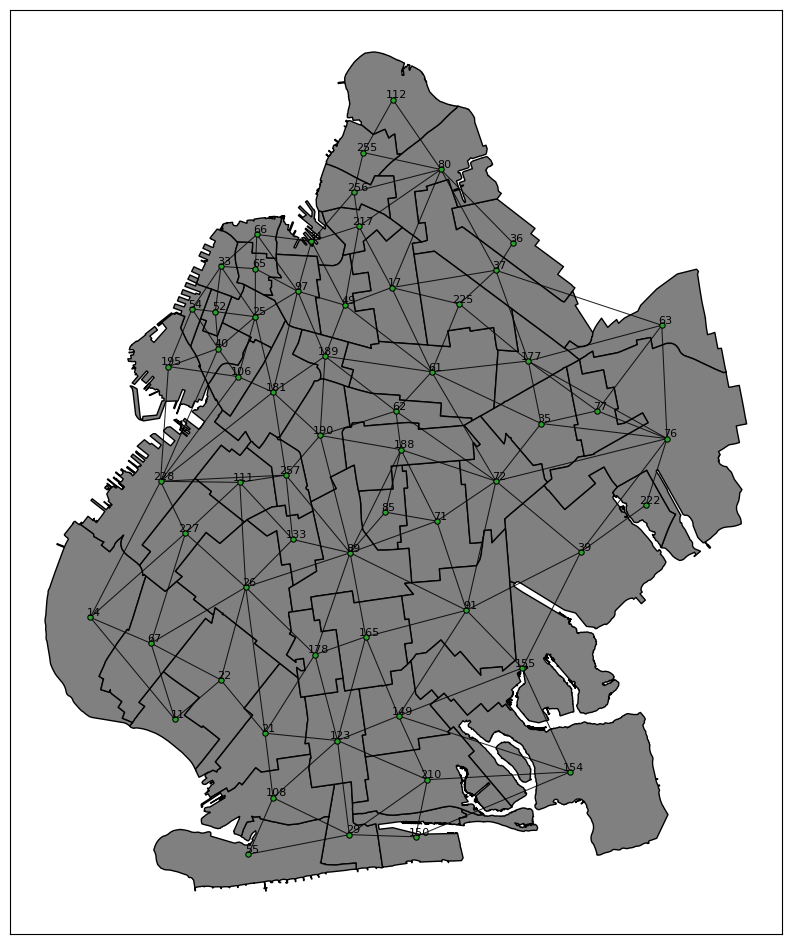

In [32]:
taxi_zone = TaxiZones(boroughs=['Brooklyn'])
plot_zones(taxi_zone);

In [33]:
trip_counts = load_and_count_trip_records('2023-01', end_month='2023-12', dataset='yellow',
                    drop_other_columns=True, freq='h', taxi_zones=taxi_zone)
trip_data = pd.DataFrame(
    {   
        'PULocationID': trip_counts.index.get_level_values('PULocationID').values,
        'hour': trip_counts.index.get_level_values('datetime').hour.values,
        'dayofweek': trip_counts.index.get_level_values('datetime').dayofweek.values,
        'dayofyear': trip_counts.index.get_level_values('datetime').to_period('h').dayofyear.values,
        'month': trip_counts.index.get_level_values('datetime').month.values,
        'quarter': trip_counts.index.get_level_values('datetime').quarter.values,
        'PU_count': trip_counts.values.ravel()
    }
)


12it [00:14,  1.23s/it]


In [48]:
zone_filter = trip_counts.index.get_level_values('PULocationID').isin(taxi_zone.zones.LocationID)
trip_data_filtered = trip_data[zone_filter]
trip_data_filtered[['x', 'y']] = trip_data_filtered['PULocationID'].apply(lambda x: pd.Series([TaxiZones.zones['x'][TaxiZones.loc_id_to_idx[x]],
                                                                            TaxiZones.zones['y'][TaxiZones.loc_id_to_idx[x]]]))
trip_data_filtered.head()

C:\Users\merti\AppData\Local\Temp\ipykernel_31300\1388844174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_data_filtered[['x', 'y']] = trip_data_filtered['PULocationID'].apply(lambda x: pd.Series([TaxiZones.zones['x'][TaxiZones.loc_id_to_idx[x]],
C:\Users\merti\AppData\Local\Temp\ipykernel_31300\1388844174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_data_filtered[['x', 'y']] = trip_data_filtered['PULocationID'].apply(lambda x: pd.Series([TaxiZones.zones['x'][TaxiZones.loc_id_to_idx[x

,PULocationID,hour,dayofweek,dayofyear,month,quarter,PU_count,x,y
87600,11,0,6,1,1,1,0,982170.783234,159429.316884
87601,11,1,6,1,1,1,0,982170.783234,159429.316884
87602,11,2,6,1,1,1,0,982170.783234,159429.316884
87603,11,3,6,1,1,1,0,982170.783234,159429.316884
87604,11,4,6,1,1,1,1,982170.783234,159429.316884


## Pre-processing of NYC Historical Weather Records
The historical weather records include